### Test Tabnet on Employee Attrition Data

In [31]:
import pandas as pd
import numpy as np
import ads

from ads import set_auth
from ads.model.generic_model import GenericModel

import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer

from pytorch_tabnet.metrics import Metric

from sklearn.metrics import classification_report
from sklearn.metrics import get_scorer, make_scorer, f1_score
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from ads.dataset.factory import DatasetFactory

import optuna

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import logging
import warnings

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

%matplotlib inline

In [32]:
print(ads.__version__)

2.6.2


In [33]:
# set RP
set_auth(auth='resource_principal')

In [3]:
attrition_path = "/opt/notebooks/ads-examples/oracle_data/orcl_attrition.csv"

# uso ancora la classe dataset per fare l'upsampling

ds = DatasetFactory.open(
      attrition_path,
      target="Attrition").set_positive_class('Yes')

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
# lavoro ancora sul dataset up sampled

ds_up = ds.up_sample()

In [5]:
cols_to_drop = ['Directs','name', 'Over18','WeeklyWorkedHours','EmployeeNumber']

ds_used = ds_up.drop(columns=cols_to_drop)

In [6]:
TARGET = 'Attrition'

features = list(set(ds_used.columns) - set([TARGET]))

features

['EducationalLevel',
 'TravelForWork',
 'MonthlyRate',
 'TrainingTimesLastYear',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'YearsAtCurrentLevel',
 'Gender',
 'MaritalStatus',
 'Age',
 'JobInvolvement',
 'MonthlyIncome',
 'JobLevel',
 'JobSatisfaction',
 'YearsinIndustry',
 'JobRole',
 'WorkLifeBalance',
 'CommuteLength',
 'YearsSinceLastPromotion',
 'YearsOnJob',
 'YearsWithCurrManager',
 'PercentSalaryHike',
 'OverTime',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'SalaryLevel',
 'JobFunction',
 'EducationField',
 'PerformanceRating',
 'NumCompaniesWorked']

In [7]:
# take the Pandas DataFRame out

# versione differente di ADS (2.0... il metodo ha altro nome)
df_used = ds_used.to_pandas()

### lavorando direttamente senza AutoML dobbiamo provvedere noi a tutta la data preparation

In [8]:
THR = 10

nunique = df_used.nunique()
types = df_used.dtypes

categorical_columns = []
categorical_dims =  {}
for col in df_used.columns:
    
    # identifichiamo come categoriche tutte le colonne che soddisfano questa condizione !!!
    # la soglia la possiamo cambiare
    if types[col] == 'object' or nunique[col] < THR:
        print(col, df_used[col].nunique())
        
        # codifichiamo i categorici con LabelEncoder
        l_enc = LabelEncoder()
        df_used[col] = l_enc.fit_transform(df_used[col].values)
        
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)

TravelForWork 3
JobFunction 3
EducationalLevel 5
EducationField 6
EnvironmentSatisfaction 4
Gender 2
JobInvolvement 4
JobLevel 5
JobRole 9
JobSatisfaction 4
MaritalStatus 3
OverTime 2
PerformanceRating 2
RelationshipSatisfaction 4
StockOptionLevel 4
TrainingTimesLastYear 7
WorkLifeBalance 4
Attrition 2


In [9]:
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [10]:
# now we have codified everything, are ready

In [11]:
X = df_used[features].values
y = df_used[TARGET].values

X.shape

(2466, 30)

In [12]:
# train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state = 1234)

print("# of samples in train set", X_train.shape[0])
print("# of samples in test set", X_test.shape[0])

# of samples in train set 1972
# of samples in test set 494


In [13]:
#
# if we need F we need a custom implementation for F1 in Tabnet
#
class F1(Metric):
    def __init__(self):
        self._name = "f1"
        self._maximize = True
        # potremmo lavorare siu questa soglia
        self.thr = 0.55
    
    # the input are probs, must be converted to 0, 1
    def __call__(self, y_true, p_score):
        
        # here we have labels
        y_score = (p_score[:, 1] >= self.thr).astype(int)
        
        return f1_score(y_true, y_score)

In [18]:
%%time
# see: https://github.com/dreamquark-ai/tabnet

# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax' # "sparsemax"
)

unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_test],
    pretraining_ratio=0.6,
    max_epochs = 200,
)

Device used : cpu
epoch 0  | loss: 5.73952 | val_0_unsup_loss: 84.98553|  0:00:00s
epoch 1  | loss: 4.88445 | val_0_unsup_loss: 76.41708|  0:00:00s
epoch 2  | loss: 4.43291 | val_0_unsup_loss: 27.87411|  0:00:01s
epoch 3  | loss: 4.11201 | val_0_unsup_loss: 11.66122|  0:00:01s
epoch 4  | loss: 3.82184 | val_0_unsup_loss: 5.70717 |  0:00:01s
epoch 5  | loss: 3.62041 | val_0_unsup_loss: 5.24278 |  0:00:02s
epoch 6  | loss: 3.33839 | val_0_unsup_loss: 4.93974 |  0:00:02s
epoch 7  | loss: 3.20272 | val_0_unsup_loss: 4.85165 |  0:00:02s
epoch 8  | loss: 3.10383 | val_0_unsup_loss: 4.42849 |  0:00:02s
epoch 9  | loss: 2.94643 | val_0_unsup_loss: 4.66951 |  0:00:03s
epoch 10 | loss: 2.84981 | val_0_unsup_loss: 4.6069  |  0:00:03s
epoch 11 | loss: 2.75457 | val_0_unsup_loss: 4.05511 |  0:00:03s
epoch 12 | loss: 2.69408 | val_0_unsup_loss: 3.82569 |  0:00:04s
epoch 13 | loss: 2.58506 | val_0_unsup_loss: 3.3961  |  0:00:04s
epoch 14 | loss: 2.55956 | val_0_unsup_loss: 3.12735 |  0:00:04s
epoch 1

In [19]:
#
# In questo caso ho preferito utilizzare direttamente Optuna (su cui è basato ADSTuner)
#

# split in due parti la seconda ottimizzo con Optuna

# la valutazione la facciamo sull'accuracy

def objective(trial):
    n_steps = trial.suggest_int("n_steps", 1, 10)
    gamma = trial.suggest_float("gamma", 1.0, 2.0)
    
    params = {
        "cat_idxs" : cat_idxs,
        "cat_dims" : cat_dims,
        "n_steps" : n_steps,
        "gamma" : gamma,
        "seed" : 0,
        "verbose" : 10
    }
    clf = TabNetClassifier(**params)

    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_name=['train', 'valid'],
        eval_metric=['auc', 'accuracy'],
        from_unsupervised=unsupervised_model,
        batch_size=128, 
        max_epochs = 100
    )
    
    y_pred = clf.predict(X_test)
    
    return round(accuracy_score(y_test, y_pred), 5)

In [20]:
#
# cre<te an launch the study
#
study = optuna.create_study(direction="maximize")

study.optimize(objective, n_trials=20)

[I 2022-07-05 09:30:50,531] A new study created in memory with name: no-name-e0ccec31-4412-45da-a62c-37233c92bd9a


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.72597 | train_auc: 0.71874 | train_accuracy: 0.66075 | valid_auc: 0.70413 | valid_accuracy: 0.65385 |  0:00:00s
epoch 10 | loss: 0.19295 | train_auc: 0.9657  | train_accuracy: 0.8783  | valid_auc: 0.90841 | valid_accuracy: 0.81579 |  0:00:09s
epoch 20 | loss: 0.11566 | train_auc: 0.99182 | train_accuracy: 0.97211 | valid_auc: 0.94723 | valid_accuracy: 0.91296 |  0:00:18s
epoch 30 | loss: 0.09205 | train_auc: 0.99663 | train_accuracy: 0.97566 | valid_auc: 0.9563  | valid_accuracy: 0.90081 |  0:00:26s

Early stopping occurred at epoch 33 with best_epoch = 23 and best_valid_accuracy = 0.9251
Best weights from best epoch are automatically used!


[I 2022-07-05 09:31:20,380] Trial 0 finished with value: 0.9251 and parameters: {'n_steps': 9, 'gamma': 1.3808223985047285}. Best is trial 0 with value: 0.9251.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.71293 | train_auc: 0.73519 | train_accuracy: 0.67495 | valid_auc: 0.72744 | valid_accuracy: 0.66599 |  0:00:00s
epoch 10 | loss: 0.21073 | train_auc: 0.97094 | train_accuracy: 0.92241 | valid_auc: 0.91135 | valid_accuracy: 0.8664  |  0:00:09s
epoch 20 | loss: 0.11123 | train_auc: 0.98737 | train_accuracy: 0.9356  | valid_auc: 0.93921 | valid_accuracy: 0.88462 |  0:00:18s
epoch 30 | loss: 0.05916 | train_auc: 0.99963 | train_accuracy: 0.99391 | valid_auc: 0.9596  | valid_accuracy: 0.89879 |  0:00:26s

Early stopping occurred at epoch 35 with best_epoch = 25 and best_valid_accuracy = 0.92308
Best weights from best epoch are automatically used!


[I 2022-07-05 09:31:52,078] Trial 1 finished with value: 0.92308 and parameters: {'n_steps': 2, 'gamma': 1.0398468117132853}. Best is trial 0 with value: 0.9251.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.73727 | train_auc: 0.71266 | train_accuracy: 0.64909 | valid_auc: 0.68714 | valid_accuracy: 0.62551 |  0:00:00s
epoch 10 | loss: 0.20233 | train_auc: 0.96031 | train_accuracy: 0.88235 | valid_auc: 0.91394 | valid_accuracy: 0.84008 |  0:00:09s
epoch 20 | loss: 0.1268  | train_auc: 0.98599 | train_accuracy: 0.95335 | valid_auc: 0.92506 | valid_accuracy: 0.87652 |  0:00:18s
epoch 30 | loss: 0.07004 | train_auc: 0.9987  | train_accuracy: 0.98479 | valid_auc: 0.95936 | valid_accuracy: 0.90283 |  0:00:26s
epoch 40 | loss: 0.08562 | train_auc: 0.99842 | train_accuracy: 0.98631 | valid_auc: 0.94866 | valid_accuracy: 0.91093 |  0:00:35s

Early stopping occurred at epoch 44 with best_epoch = 34 and best_valid_accuracy = 0.92713
Best weights from best epoch are automatically used!


[I 2022-07-05 09:32:31,731] Trial 2 finished with value: 0.92713 and parameters: {'n_steps': 5, 'gamma': 1.6804153470298342}. Best is trial 2 with value: 0.92713.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.72905 | train_auc: 0.69587 | train_accuracy: 0.64047 | valid_auc: 0.68161 | valid_accuracy: 0.6417  |  0:00:00s
epoch 10 | loss: 0.21877 | train_auc: 0.97343 | train_accuracy: 0.89097 | valid_auc: 0.91684 | valid_accuracy: 0.81984 |  0:00:09s
epoch 20 | loss: 0.11237 | train_auc: 0.99292 | train_accuracy: 0.96552 | valid_auc: 0.94116 | valid_accuracy: 0.89069 |  0:00:18s

Early stopping occurred at epoch 27 with best_epoch = 17 and best_valid_accuracy = 0.90891
Best weights from best epoch are automatically used!


[I 2022-07-05 09:32:54,894] Trial 3 finished with value: 0.90891 and parameters: {'n_steps': 10, 'gamma': 1.4639149033138008}. Best is trial 2 with value: 0.92713.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.73793 | train_auc: 0.72116 | train_accuracy: 0.66633 | valid_auc: 0.69827 | valid_accuracy: 0.66802 |  0:00:00s
epoch 10 | loss: 0.22604 | train_auc: 0.93605 | train_accuracy: 0.87018 | valid_auc: 0.88198 | valid_accuracy: 0.80769 |  0:00:07s
epoch 20 | loss: 0.15289 | train_auc: 0.99222 | train_accuracy: 0.96856 | valid_auc: 0.93483 | valid_accuracy: 0.89271 |  0:00:13s
epoch 30 | loss: 0.07815 | train_auc: 0.99875 | train_accuracy: 0.98783 | valid_auc: 0.95645 | valid_accuracy: 0.91498 |  0:00:19s
epoch 40 | loss: 0.07608 | train_auc: 0.99965 | train_accuracy: 0.99189 | valid_auc: 0.96035 | valid_accuracy: 0.88664 |  0:00:26s

Early stopping occurred at epoch 41 with best_epoch = 31 and best_valid_accuracy = 0.92308
Best weights from best epoch are automatically used!


[I 2022-07-05 09:33:22,204] Trial 4 finished with value: 0.92308 and parameters: {'n_steps': 9, 'gamma': 1.9884809515316235}. Best is trial 2 with value: 0.92713.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.73415 | train_auc: 0.72336 | train_accuracy: 0.66329 | valid_auc: 0.70496 | valid_accuracy: 0.65789 |  0:00:00s
epoch 10 | loss: 0.23626 | train_auc: 0.96854 | train_accuracy: 0.88895 | valid_auc: 0.9141  | valid_accuracy: 0.81579 |  0:00:06s
epoch 20 | loss: 0.12594 | train_auc: 0.99542 | train_accuracy: 0.97667 | valid_auc: 0.9428  | valid_accuracy: 0.88664 |  0:00:13s
epoch 30 | loss: 0.07454 | train_auc: 0.99759 | train_accuracy: 0.98834 | valid_auc: 0.95888 | valid_accuracy: 0.90891 |  0:00:19s
epoch 40 | loss: 0.09965 | train_auc: 0.99544 | train_accuracy: 0.97617 | valid_auc: 0.94402 | valid_accuracy: 0.88057 |  0:00:25s

Early stopping occurred at epoch 44 with best_epoch = 34 and best_valid_accuracy = 0.92915
Best weights from best epoch are automatically used!


[I 2022-07-05 09:33:51,005] Trial 5 finished with value: 0.92915 and parameters: {'n_steps': 2, 'gamma': 1.7543947826932837}. Best is trial 5 with value: 0.92915.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.72861 | train_auc: 0.73953 | train_accuracy: 0.67343 | valid_auc: 0.74986 | valid_accuracy: 0.67814 |  0:00:00s
epoch 10 | loss: 0.22398 | train_auc: 0.95337 | train_accuracy: 0.88032 | valid_auc: 0.87064 | valid_accuracy: 0.80972 |  0:00:06s
epoch 20 | loss: 0.12502 | train_auc: 0.99424 | train_accuracy: 0.964   | valid_auc: 0.93995 | valid_accuracy: 0.88664 |  0:00:13s
epoch 30 | loss: 0.0696  | train_auc: 0.99844 | train_accuracy: 0.98428 | valid_auc: 0.94333 | valid_accuracy: 0.89271 |  0:00:19s

Early stopping occurred at epoch 31 with best_epoch = 21 and best_valid_accuracy = 0.91296
Best weights from best epoch are automatically used!


[I 2022-07-05 09:34:11,593] Trial 6 finished with value: 0.91296 and parameters: {'n_steps': 8, 'gamma': 1.5384087502516142}. Best is trial 5 with value: 0.92915.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.73646 | train_auc: 0.73738 | train_accuracy: 0.69726 | valid_auc: 0.73167 | valid_accuracy: 0.69028 |  0:00:00s
epoch 10 | loss: 0.20187 | train_auc: 0.96773 | train_accuracy: 0.88945 | valid_auc: 0.89341 | valid_accuracy: 0.81781 |  0:00:07s
epoch 20 | loss: 0.10532 | train_auc: 0.99896 | train_accuracy: 0.98529 | valid_auc: 0.94754 | valid_accuracy: 0.88866 |  0:00:13s
epoch 30 | loss: 0.05926 | train_auc: 0.999   | train_accuracy: 0.98022 | valid_auc: 0.94213 | valid_accuracy: 0.88057 |  0:00:19s

Early stopping occurred at epoch 38 with best_epoch = 28 and best_valid_accuracy = 0.92915
Best weights from best epoch are automatically used!


[I 2022-07-05 09:34:36,803] Trial 7 finished with value: 0.92915 and parameters: {'n_steps': 7, 'gamma': 1.886983757224714}. Best is trial 5 with value: 0.92915.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.71272 | train_auc: 0.75133 | train_accuracy: 0.69168 | valid_auc: 0.75576 | valid_accuracy: 0.67814 |  0:00:00s
epoch 10 | loss: 0.19247 | train_auc: 0.98241 | train_accuracy: 0.91379 | valid_auc: 0.92188 | valid_accuracy: 0.8583  |  0:00:06s
epoch 20 | loss: 0.11074 | train_auc: 0.99547 | train_accuracy: 0.98631 | valid_auc: 0.95511 | valid_accuracy: 0.88664 |  0:00:13s
epoch 30 | loss: 0.07591 | train_auc: 0.99703 | train_accuracy: 0.98783 | valid_auc: 0.95025 | valid_accuracy: 0.90283 |  0:00:19s
epoch 40 | loss: 0.0747  | train_auc: 0.99801 | train_accuracy: 0.97819 | valid_auc: 0.96602 | valid_accuracy: 0.90283 |  0:00:25s
epoch 50 | loss: 0.06521 | train_auc: 0.99987 | train_accuracy: 0.99493 | valid_auc: 0.94638 | valid_accuracy: 0.89676 |  0:00:32s

Early stopping occurred at epoch 53 with best_epoch = 43 and best_valid_accuracy = 0.92308
Best weights from best epoch are automatically used!


[I 2022-07-05 09:35:11,475] Trial 8 finished with value: 0.92308 and parameters: {'n_steps': 2, 'gamma': 1.0572169541124192}. Best is trial 5 with value: 0.92915.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.72637 | train_auc: 0.70279 | train_accuracy: 0.6572  | valid_auc: 0.69042 | valid_accuracy: 0.6498  |  0:00:00s
epoch 10 | loss: 0.24139 | train_auc: 0.96469 | train_accuracy: 0.89807 | valid_auc: 0.9102  | valid_accuracy: 0.84413 |  0:00:07s
epoch 20 | loss: 0.14574 | train_auc: 0.99621 | train_accuracy: 0.97617 | valid_auc: 0.93872 | valid_accuracy: 0.88259 |  0:00:13s
epoch 30 | loss: 0.07442 | train_auc: 0.9953  | train_accuracy: 0.97008 | valid_auc: 0.92278 | valid_accuracy: 0.87854 |  0:00:19s
epoch 40 | loss: 0.09106 | train_auc: 0.99668 | train_accuracy: 0.98225 | valid_auc: 0.93305 | valid_accuracy: 0.88866 |  0:00:25s

Early stopping occurred at epoch 44 with best_epoch = 34 and best_valid_accuracy = 0.93117
Best weights from best epoch are automatically used!


[I 2022-07-05 09:35:40,438] Trial 9 finished with value: 0.93117 and parameters: {'n_steps': 5, 'gamma': 1.9037201327662776}. Best is trial 9 with value: 0.93117.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.71884 | train_auc: 0.70874 | train_accuracy: 0.66329 | valid_auc: 0.68582 | valid_accuracy: 0.63765 |  0:00:00s
epoch 10 | loss: 0.24953 | train_auc: 0.97399 | train_accuracy: 0.91481 | valid_auc: 0.92178 | valid_accuracy: 0.84818 |  0:00:07s
epoch 20 | loss: 0.12683 | train_auc: 0.99587 | train_accuracy: 0.97363 | valid_auc: 0.93963 | valid_accuracy: 0.88259 |  0:00:13s
epoch 30 | loss: 0.08662 | train_auc: 0.99524 | train_accuracy: 0.96552 | valid_auc: 0.95641 | valid_accuracy: 0.89474 |  0:00:19s

Early stopping occurred at epoch 39 with best_epoch = 29 and best_valid_accuracy = 0.9251
Best weights from best epoch are automatically used!


[I 2022-07-05 09:36:06,301] Trial 10 finished with value: 0.9251 and parameters: {'n_steps': 5, 'gamma': 1.3136217289236705}. Best is trial 9 with value: 0.93117.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.73155 | train_auc: 0.74686 | train_accuracy: 0.67495 | valid_auc: 0.7333  | valid_accuracy: 0.64777 |  0:00:00s
epoch 10 | loss: 0.17768 | train_auc: 0.9753  | train_accuracy: 0.92596 | valid_auc: 0.91036 | valid_accuracy: 0.8502  |  0:00:07s
epoch 20 | loss: 0.09895 | train_auc: 0.99635 | train_accuracy: 0.97972 | valid_auc: 0.96169 | valid_accuracy: 0.90081 |  0:00:13s
epoch 30 | loss: 0.07301 | train_auc: 0.99662 | train_accuracy: 0.98073 | valid_auc: 0.95931 | valid_accuracy: 0.89879 |  0:00:19s

Early stopping occurred at epoch 31 with best_epoch = 21 and best_valid_accuracy = 0.92713
Best weights from best epoch are automatically used!


[I 2022-07-05 09:36:26,957] Trial 11 finished with value: 0.92713 and parameters: {'n_steps': 1, 'gamma': 1.7787051955743958}. Best is trial 9 with value: 0.93117.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.73175 | train_auc: 0.74113 | train_accuracy: 0.66126 | valid_auc: 0.72992 | valid_accuracy: 0.63158 |  0:00:00s
epoch 10 | loss: 0.21388 | train_auc: 0.97217 | train_accuracy: 0.92444 | valid_auc: 0.92065 | valid_accuracy: 0.85628 |  0:00:07s
epoch 20 | loss: 0.13208 | train_auc: 0.99063 | train_accuracy: 0.96602 | valid_auc: 0.94754 | valid_accuracy: 0.89676 |  0:00:13s
epoch 30 | loss: 0.09223 | train_auc: 0.99848 | train_accuracy: 0.98935 | valid_auc: 0.94858 | valid_accuracy: 0.89271 |  0:00:19s

Early stopping occurred at epoch 31 with best_epoch = 21 and best_valid_accuracy = 0.91296
Best weights from best epoch are automatically used!


[I 2022-07-05 09:36:47,721] Trial 12 finished with value: 0.91296 and parameters: {'n_steps': 4, 'gamma': 1.7171044677135545}. Best is trial 9 with value: 0.93117.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.73716 | train_auc: 0.73941 | train_accuracy: 0.68408 | valid_auc: 0.72469 | valid_accuracy: 0.68016 |  0:00:00s
epoch 10 | loss: 0.21548 | train_auc: 0.95226 | train_accuracy: 0.84888 | valid_auc: 0.89469 | valid_accuracy: 0.81174 |  0:00:06s
epoch 20 | loss: 0.1207  | train_auc: 0.9986  | train_accuracy: 0.98073 | valid_auc: 0.94948 | valid_accuracy: 0.88057 |  0:00:13s
epoch 30 | loss: 0.05029 | train_auc: 0.99983 | train_accuracy: 0.9929  | valid_auc: 0.9502  | valid_accuracy: 0.88866 |  0:00:19s

Early stopping occurred at epoch 33 with best_epoch = 23 and best_valid_accuracy = 0.90891
Best weights from best epoch are automatically used!


[I 2022-07-05 09:37:09,506] Trial 13 finished with value: 0.90891 and parameters: {'n_steps': 3, 'gamma': 1.9775534250080362}. Best is trial 9 with value: 0.93117.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.73335 | train_auc: 0.7081  | train_accuracy: 0.65568 | valid_auc: 0.67774 | valid_accuracy: 0.6336  |  0:00:00s
epoch 10 | loss: 0.21154 | train_auc: 0.97237 | train_accuracy: 0.92951 | valid_auc: 0.92562 | valid_accuracy: 0.87652 |  0:00:07s
epoch 20 | loss: 0.12193 | train_auc: 0.99698 | train_accuracy: 0.9858  | valid_auc: 0.9632  | valid_accuracy: 0.91296 |  0:00:13s
epoch 30 | loss: 0.07656 | train_auc: 0.99867 | train_accuracy: 0.9858  | valid_auc: 0.96541 | valid_accuracy: 0.9251  |  0:00:19s
epoch 40 | loss: 0.06863 | train_auc: 0.99942 | train_accuracy: 0.99037 | valid_auc: 0.95153 | valid_accuracy: 0.90283 |  0:00:25s

Early stopping occurred at epoch 41 with best_epoch = 31 and best_valid_accuracy = 0.93725
Best weights from best epoch are automatically used!


[I 2022-07-05 09:37:36,472] Trial 14 finished with value: 0.93725 and parameters: {'n_steps': 6, 'gamma': 1.823432125206781}. Best is trial 14 with value: 0.93725.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.73315 | train_auc: 0.71668 | train_accuracy: 0.65213 | valid_auc: 0.69305 | valid_accuracy: 0.62955 |  0:00:00s
epoch 10 | loss: 0.20496 | train_auc: 0.96055 | train_accuracy: 0.85649 | valid_auc: 0.89889 | valid_accuracy: 0.80567 |  0:00:06s
epoch 20 | loss: 0.1098  | train_auc: 0.993   | train_accuracy: 0.964   | valid_auc: 0.94365 | valid_accuracy: 0.87449 |  0:00:13s
epoch 30 | loss: 0.07329 | train_auc: 0.99938 | train_accuracy: 0.98022 | valid_auc: 0.94733 | valid_accuracy: 0.87854 |  0:00:19s

Early stopping occurred at epoch 35 with best_epoch = 25 and best_valid_accuracy = 0.91093
Best weights from best epoch are automatically used!


[I 2022-07-05 09:37:59,895] Trial 15 finished with value: 0.91093 and parameters: {'n_steps': 6, 'gamma': 1.6070058010574575}. Best is trial 14 with value: 0.93725.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.73447 | train_auc: 0.72034 | train_accuracy: 0.67292 | valid_auc: 0.70482 | valid_accuracy: 0.65182 |  0:00:00s
epoch 10 | loss: 0.22789 | train_auc: 0.9496  | train_accuracy: 0.88438 | valid_auc: 0.90313 | valid_accuracy: 0.84008 |  0:00:07s
epoch 20 | loss: 0.11984 | train_auc: 0.9964  | train_accuracy: 0.96856 | valid_auc: 0.93647 | valid_accuracy: 0.88664 |  0:00:13s
epoch 30 | loss: 0.06991 | train_auc: 0.99649 | train_accuracy: 0.9787  | valid_auc: 0.92848 | valid_accuracy: 0.86437 |  0:00:20s
epoch 40 | loss: 0.07888 | train_auc: 0.99876 | train_accuracy: 0.9858  | valid_auc: 0.946   | valid_accuracy: 0.89676 |  0:00:26s

Early stopping occurred at epoch 45 with best_epoch = 35 and best_valid_accuracy = 0.917
Best weights from best epoch are automatically used!


[I 2022-07-05 09:38:30,031] Trial 16 finished with value: 0.917 and parameters: {'n_steps': 6, 'gamma': 1.8528827125444858}. Best is trial 14 with value: 0.93725.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.73524 | train_auc: 0.70409 | train_accuracy: 0.65264 | valid_auc: 0.69178 | valid_accuracy: 0.62955 |  0:00:00s
epoch 10 | loss: 0.19666 | train_auc: 0.98032 | train_accuracy: 0.93408 | valid_auc: 0.9175  | valid_accuracy: 0.84818 |  0:00:07s
epoch 20 | loss: 0.11012 | train_auc: 0.99576 | train_accuracy: 0.97972 | valid_auc: 0.94382 | valid_accuracy: 0.88866 |  0:00:13s

Early stopping occurred at epoch 27 with best_epoch = 17 and best_valid_accuracy = 0.93117
Best weights from best epoch are automatically used!


[I 2022-07-05 09:38:48,782] Trial 17 finished with value: 0.93117 and parameters: {'n_steps': 4, 'gamma': 1.866297910060952}. Best is trial 14 with value: 0.93725.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.73441 | train_auc: 0.71508 | train_accuracy: 0.66278 | valid_auc: 0.67928 | valid_accuracy: 0.64777 |  0:00:00s
epoch 10 | loss: 0.20421 | train_auc: 0.96104 | train_accuracy: 0.89199 | valid_auc: 0.91893 | valid_accuracy: 0.83198 |  0:00:07s
epoch 20 | loss: 0.14688 | train_auc: 0.9878  | train_accuracy: 0.95132 | valid_auc: 0.91991 | valid_accuracy: 0.87449 |  0:00:13s

Early stopping occurred at epoch 25 with best_epoch = 15 and best_valid_accuracy = 0.917
Best weights from best epoch are automatically used!


[I 2022-07-05 09:39:05,833] Trial 18 finished with value: 0.917 and parameters: {'n_steps': 4, 'gamma': 1.6280263867928626}. Best is trial 14 with value: 0.93725.


Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.70995 | train_auc: 0.73923 | train_accuracy: 0.65517 | valid_auc: 0.75386 | valid_accuracy: 0.65992 |  0:00:00s
epoch 10 | loss: 0.21756 | train_auc: 0.95625 | train_accuracy: 0.89148 | valid_auc: 0.90711 | valid_accuracy: 0.81984 |  0:00:06s
epoch 20 | loss: 0.13763 | train_auc: 0.98842 | train_accuracy: 0.95385 | valid_auc: 0.94774 | valid_accuracy: 0.87652 |  0:00:13s

Early stopping occurred at epoch 28 with best_epoch = 18 and best_valid_accuracy = 0.90688
Best weights from best epoch are automatically used!


[I 2022-07-05 09:39:24,635] Trial 19 finished with value: 0.90688 and parameters: {'n_steps': 7, 'gamma': 1.1779432532646972}. Best is trial 14 with value: 0.93725.


In [21]:
study.best_params

{'n_steps': 6, 'gamma': 1.823432125206781}

In [22]:
# train with best params: {'n_steps': 6, 'gamma': 1.823432125206781}
# il risultato è riproducibile

params = {
    "cat_idxs" : cat_idxs,
    "cat_dims" : cat_dims,
    "n_steps" : study.best_params['n_steps'],
    "gamma" : study.best_params['gamma'],
    "verbose" : 5
    }
clf = TabNetClassifier(**params)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'valid'],
    eval_metric=['auc', 'accuracy'],
    from_unsupervised=unsupervised_model,
    batch_size=128, 
    max_epochs = 50
)

Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.73335 | train_auc: 0.7081  | train_accuracy: 0.65568 | valid_auc: 0.67774 | valid_accuracy: 0.6336  |  0:00:00s
epoch 5  | loss: 0.31904 | train_auc: 0.91387 | train_accuracy: 0.82961 | valid_auc: 0.87193 | valid_accuracy: 0.7915  |  0:00:03s
epoch 10 | loss: 0.21154 | train_auc: 0.97237 | train_accuracy: 0.92951 | valid_auc: 0.92562 | valid_accuracy: 0.87652 |  0:00:07s
epoch 15 | loss: 0.15628 | train_auc: 0.99101 | train_accuracy: 0.95892 | valid_auc: 0.94251 | valid_accuracy: 0.87652 |  0:00:10s
epoch 20 | loss: 0.12193 | train_auc: 0.99698 | train_accuracy: 0.9858  | valid_auc: 0.9632  | valid_accuracy: 0.91296 |  0:00:13s
epoch 25 | loss: 0.07446 | train_auc: 0.99793 | train_accuracy: 0.98884 | valid_auc: 0.95975 | valid_accuracy: 0.91093 |  0:00:16s
epoch 30 | loss: 0.07656 | train_auc: 0.99867 | train_accuracy: 0.9858  | valid_auc: 0.96541 | valid_accuracy: 0.9251  |  0:00:19s
epoch 35 | loss: 0.

In [23]:
# migliorata significativamente con la gestione delle categoriche e sopratutto pre-training

test_pred = clf.predict(X_test)
test_probas = clf.predict_proba(X_test)

print('Test set Classification Report:')
print(classification_report(y_test, test_pred, digits=4))

print("ROC AUC",round(roc_auc_score(y_test, test_probas[:,1]), 3))

Test set Classification Report:
              precision    recall  f1-score   support

           0     0.9828    0.8941    0.9363       255
           1     0.8969    0.9833    0.9381       239

    accuracy                         0.9372       494
   macro avg     0.9399    0.9387    0.9372       494
weighted avg     0.9412    0.9372    0.9372       494

ROC AUC 0.968


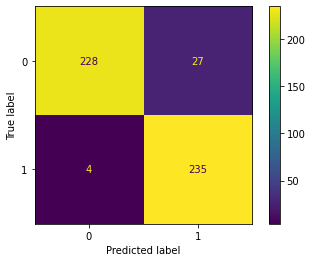

In [24]:
def plot_cm(model, x_test, y_test):
    y_pred_labels = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot();
    
plot_cm(clf, X_test, y_test)

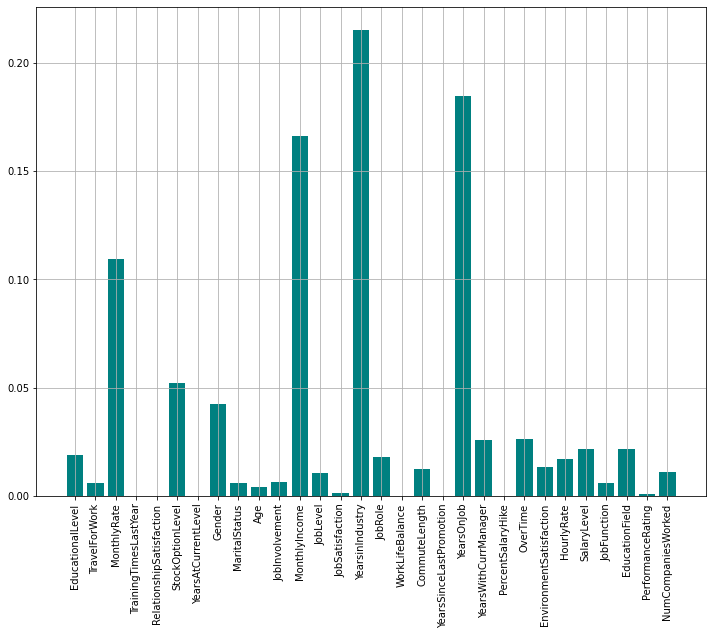

In [25]:
plt.figure(figsize=(12,9))
plt.bar(x=features, height=clf.feature_importances_)
plt.xticks(rotation=90)
plt.grid(True)
plt.show();

In [27]:
saving_path_name = "./tabnet_model/tabnet_model"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model/tabnet_model.zip


In [37]:
ads_model = GenericModel(estimator=clf,
                artifact_dir="./artifact_dir"
            )

In [44]:
# here we should put the custom conda env
ads_model.prepare(inference_conda_env="pytorch110_p37_cpu_v1", force_overwrite=True)